In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
SEQ_LEN = 90
OBSERVATION_LEN = 60
ROOT_DIR = "/home/solana/automated-retraining-2/.mass_training" # TODO: adjust as needed

In [24]:
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler


def prepare_datasets(exp_name: str):
    data_file = os.path.join("/home/solana/automated-retraining-2/examples/gan/data/btcusd_1-min_data.csv") # TODO: make this a relative path
    data = pd.read_csv(data_file)
    df = data[:SEQ_LEN*int(len(data)/SEQ_LEN)]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df.set_index('Timestamp')
    df = df.dropna()
    df = df.drop(columns=['Volume', 'Open', 'High', 'Low'])
    df = df.astype('float32')
    samples = np.array_split(df['Close'].values, len(df)/SEQ_LEN)
    samples_transformed = []
    for sample in samples:
            X = sample.reshape(-1, 1)
            transformer = MinMaxScaler().fit(X[:OBSERVATION_LEN])
            transformed = transformer.transform(X)
            sample = transformed[:SEQ_LEN].squeeze()
            samples_transformed.append(sample)
    sample_batches = [samples_transformed[i:i + 1600] for i in range(0, len(samples_transformed), 1600)]
    
    for i, batch in enumerate(sample_batches):
        train, test = train_test_split(batch, test_size=0.3, shuffle=False)
        if not os.path.exists(os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}")):
            os.makedirs(os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}"))
        torch.save(train, os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}", "training_set.pt"))
        torch.save(test, os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}", "validation_set.pt"))


def scale_sample(sample):
    sample = sample.reshape(-1, 1)
    transformer = MinMaxScaler().fit(sample)
    transformed = transformer.transform(sample)
    return transformed.squeeze()

def calculate_function(f, x):
    r = 0*x
    for (a, freq, shift) in f:
        r += a*np.sin(freq*np.pi*(x + shift))
    return r

def generate_function(harmonics):
    functions_idx = np.floor(np.random.uniform(0, len(harmonics)-1, 50)).astype(int)
    params = []
    shifts = [0, 0.5*np.pi]
    for i in functions_idx:
        if i == 0:
            continue
        for shift in shifts:
            a = np.random.normal(-1, 1)
            params.append((a*(1/(5000*np.pi * harmonics[i])), harmonics[i], shift)) # 
    f = lambda z: calculate_function(params, z) 
    return f, params


def f_distance(params_a, params_b):
    p_a, a_shift = params_a
    p_b, b_shift = params_b
    params_b_dict = defaultdict(lambda: 0)
    for param in p_b:
        params_b_dict[(param[1], param[2])] = param[0] 
    squared_diffs = sum([((param[0]-params_b_dict[(param[1], param[2])]) * 5000*np.pi * param[1])**2 for param in p_a]) + (a_shift-b_shift)**2
    return np.sqrt(squared_diffs)

def c_distance(params_a, params_b, n=100):
    a_idxs = np.random.choice(len(params_a), n, replace=False)
    b_idxs = np.random.choice(len(params_b), n, replace=False)
    params_a_list = [params_a[i] for i in a_idxs]
    params_b_list = [params_b[i] for i in b_idxs]
    distance_matrix = np.zeros((n, n))
    for (i,p_a) in enumerate(params_a_list):
        for (j,p_b) in enumerate(params_b_list):
            distance_matrix[i][j] = f_distance(p_a, p_b)
    matches = []
    for i in range(len(distance_matrix)):
        min_d = 10000000
        min_d_j = -1
        for j in range(len(distance_matrix[i])):
            if distance_matrix[i][j] < min_d:
                min_d = distance_matrix[i][j]
                min_d_j = j
        matches.append([i, min_d_j, min_d])
    distances = [x[2] for x in matches]
    return np.median(distances)

def self_similarity(params_per_class):
    distances = []
    for (i, params_a) in enumerate(params_per_class):
        for j in range(len(params_per_class)):
            if i <= j:
                continue
            distances.append((j, i, c_distance(params_a, params_per_class[j])))
    return distances

def prepare_synthetic_datasets(exp_name: str, classes: int, pairs, samples_per_class: int, similarity=0.8):
    N = 100
    M = 1000
    L = 50*N*np.pi
    harmonics_f = [i/L for i in range(1, M+1)]
    harmonics_classes = [np.random.choice(harmonics_f, 10) for i in range(classes)]
    # for (i, n) in pairs:
    #     harmonics_classes[i] = np.concatenate((np.random.choice(harmonics_classes[n], int(similarity*10), replace=False), np.random.choice(harmonics_classes[i], int((1-similarity)*10), replace=False)))
    functions_per_class = [[generate_function(harmonics_classes[i]) for j in range(samples_per_class)] for i in range(classes)]
    for (i, n) in pairs:
        i_idxs = None
        n_idxs = None
        if similarity >= 0.5:
            i_idxs = np.random.choice([j for j in range(samples_per_class)], int((1-similarity)*samples_per_class), replace=False)
            n_idxs = np.random.choice([j for j in range(samples_per_class)], int(similarity*samples_per_class), replace=False)
        else:
            i_idxs = np.random.choice([j for j in range(samples_per_class)], int(similarity*samples_per_class), replace=False)
            n_idxs = np.random.choice([j for j in range(samples_per_class)], int((1-similarity)*samples_per_class), replace=False)
        functions_per_class[i] = [functions_per_class[n][i] for i in n_idxs] + [functions_per_class[i][j] for j in i_idxs]
        # np.concatenate((np.random.choice(functions_per_class[n], int(similarity*samples_per_class), replace=False), np.random.choice(functions_per_class[i], int((1-similarity)*samples_per_class), replace=False)))
    # for (i, harmonics) in enumerate(harmonics_classes):
    #     batch = []
    #     # f = generate_function(harmonics)
    #     for j in range(samples_per_class):
    #         f, params = generate_function(harmonics)
    #         b = np.random.normal(-0.5, 0.5)
    #         y = f(x) + b
    #         y = scale_sample(y)
    #         params_per_class[i].append((params, b))
    #         batch.append(y)
    samples_batches = []
    x = np.arange(0, 269, 3.0)
    params_per_class = []
    for i in range(classes):
        batch = []
        params_per_class.append([])
        for (f, params) in functions_per_class[i]:
            b = np.random.normal(-0.5, 0.5)
            y = f(x) + b
            y = scale_sample(y)
            params_per_class[i].append((params, b))
            batch.append(y)
        samples_batches.append(batch)
    
    for i, batch in enumerate(samples_batches):
        train, test = train_test_split(batch, test_size=0.3, shuffle=False)
        if not os.path.exists(os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}")):
            os.makedirs(os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}"))
        torch.save(train, os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}", "training_set.pt"))
        torch.save(test, os.path.join(ROOT_DIR, exp_name, "data", f"chunk_{i}", "validation_set.pt"))
    distances = self_similarity(params_per_class)
    scaler = MinMaxScaler()
    df = pd.DataFrame(distances, columns =['dataset_1', 'dataset_2', 'distance'])
    df[['distance']] = scaler.fit_transform(df[['distance']])
    results_path = os.path.join(ROOT_DIR, exp_name, "results")
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    df.to_csv(os.path.join(results_path, "results_freq_domain.csv"), index=False)

# Synthetic

In [25]:
for i in range(5):
    print("Generating ", i, " dataset.")
    prepare_synthetic_datasets(f"synthetic_2_30_{i}", 10, [(0, 3), (5, 3), (1,6), (4,9)], 1600, 0.3)
# prepare_synthetic_datasets("synthetic_opt_11", 1, [], 1600)

Generating  0  dataset.
Generating  1  dataset.
Generating  2  dataset.
Generating  3  dataset.
Generating  4  dataset.


# BTC

In [26]:
prepare_datasets("btc")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

/tmp/ipykernel_1233367/1234731986.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_1 = torch.load(dataset_1_path)
/tmp/ipykernel_1233367/1234731986.py:4: FutureWarni

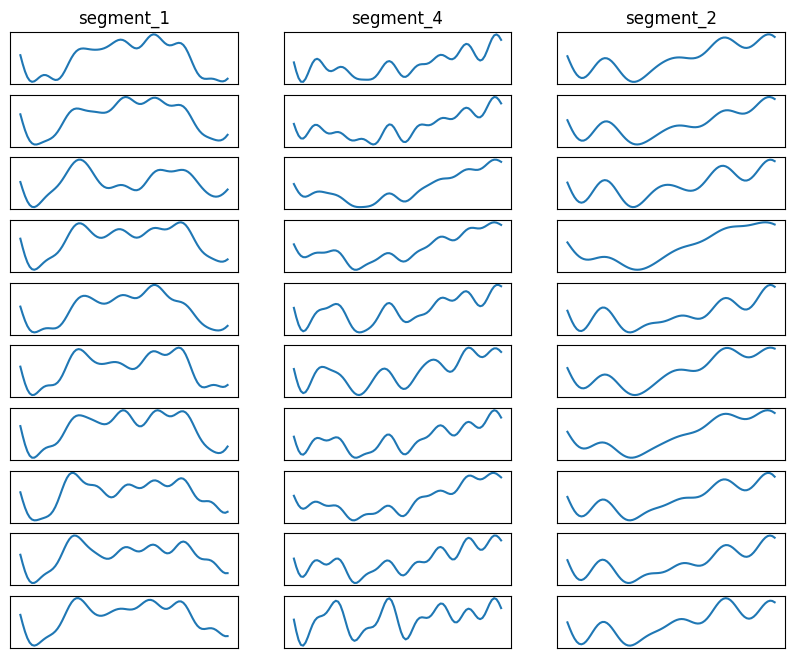

In [78]:
dataset_1_path = "/home/solana/automated-retraining-2/.mass_training/synthetic_12/data/chunk_1/training_set.pt"
data_1 = torch.load(dataset_1_path)
dataset_2_path = "/home/solana/automated-retraining-2/.mass_training/synthetic_12/data/chunk_0/training_set.pt"
data_2 = torch.load(dataset_2_path)
dataset_4_path = "/home/solana/automated-retraining-2/.mass_training/synthetic_12/data/chunk_5/training_set.pt"
data_4 = torch.load(dataset_4_path)

fig, axs = plt.subplots(10, 3, figsize=(10, 8))
x = np.arange(0, 269, 3.0)
for i in range(10):
    sample = data_1[i]
    axs[i, 0].plot(x, data_1[i])
    sample = data_4[i]
    axs[i, 1].plot(x, sample)
    sample = data_2[i]
    axs[i, 2].plot(x, sample)

cols = ['segment_1', 'segment_4', 'segment_2']
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

/tmp/ipykernel_7460/941290140.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(dataset_path)


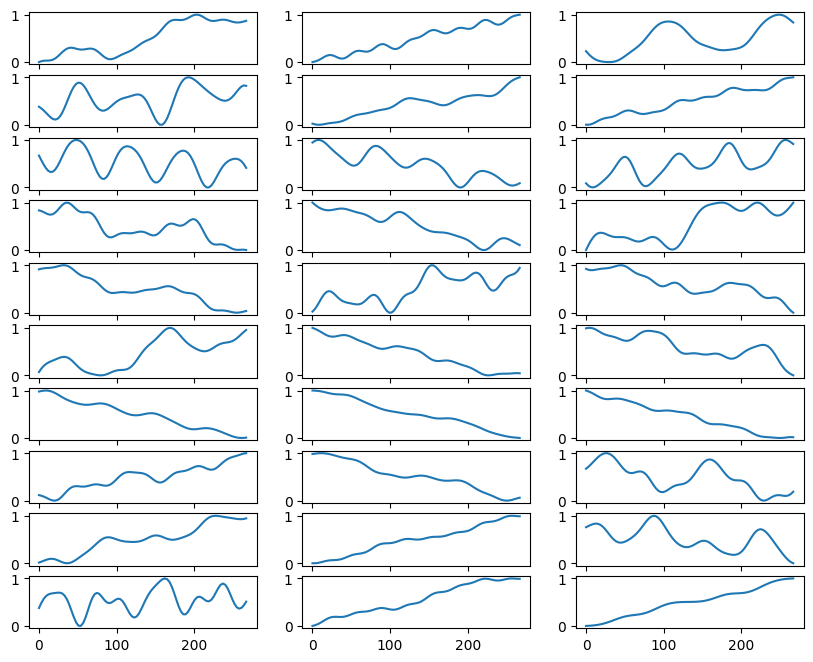

In [29]:
dataset_path = "/home/solana/automated-retraining-2/.mass_training/synthetic_3/data/chunk_3/training_set.pt"
data = torch.load(dataset_path)
fig, axs = plt.subplots(10, 3, figsize=(10, 8))
x = np.arange(0, 269, 3.0)
for i in range(10):
    for j in range(3):
        sample = data[i*3+j]
        axs[i, j].plot(x, sample)